![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## Analisis de sentimiento en opiniones de IMDB - LogRes versus NN

## 1. Primer bloque - Carguemos las opiniones para aplicar Bag of Words

Necesitaremos pandas y el CountVectorizer de sklearn para aplicar bag of words sobre las frases.


In [3]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import numpy as np
import time
import datetime

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A cargar datos del archivo imdb_labelled.txt y mostramos su primer valor

In [6]:
df = pd.read_csv('imdb_labelled.txt', names=['frases','label'], sep='\t')
print(df.iloc[0])

frases    A very, very, very slow-moving, aimless movie ...
label                                                     0
Name: 0, dtype: object


Una valoración bastante negativa... como podeis ver el label 0 es "negativo", así que 1 serà "positivo" (analizando el sentimiento de la frase)

Preparemos los datos, para tener un test y un train

In [7]:
frases = df['frases'].values
y = df['label'].values

In [8]:
frases_train, frases_test, y_train, y_test = train_test_split(frases, y, test_size=0.25, random_state=1000)

Ahora viene el momento de crear nuestro bag of words, para eso usaremos CountVectorizer de sklearn, que lo entrenaremos con las palabras/frases del train y luego aplicaremos a cada set de frases train y test

In [9]:
vectorizador = CountVectorizer()
vectorizador.fit(frases_train)

x_train = vectorizador.transform(frases_train)
x_test = vectorizador.transform(frases_test)

x_train

<561x2505 sparse matrix of type '<class 'numpy.int64'>'
	with 8413 stored elements in Compressed Sparse Row format>

In [10]:
print(x_train[0,:])

  (0, 360)	1
  (0, 532)	1
  (0, 1532)	1
  (0, 2471)	1


## 2. Primer bloque - Regression Logistica con Bag Of Words

Para empezar carguemos esas librerias que nos hacen falta

### 2.1 Cargamos las librerias para la Regression Logistica y la entrenamos con cross validation buscando el mejor parametro C de la regression logistica

In [11]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(x_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)


Best cross-validation score: 0.74
Best parameters:  {'C': 1}
Best estimator:  LogisticRegression(C=1)


In [12]:
lr = grid.best_estimator_
lr.fit(x_train, y_train)
lr.predict(x_test)

score_test = lr.score(x_test, y_test)

print('Accuracy for IMDB data in test data: {:.4f}'.format(score_test))


Accuracy for IMDB data in test data: 0.7487


## 3.Segundo bloque - Vayamos a por una red neuronal

Una red senzilla, por ahora nada de RNN

Vamos a por las librerias que necesitamos

In [13]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt

Veamos cuantas dimensiones tengo para la entrada de la primera capa de la red neuronal

In [14]:
input_dim = x_train.shape[1]
print('Numero dimensiones:', input_dim)

Numero dimensiones: 2505


Definimos el modelo de red neuronal

In [15]:
model = ks.Sequential()
model.add(ks.layers.Dense(512, input_dim=input_dim, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(256, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(50, activation='relu'))
model.add(ks.layers.Dropout(0.5))
model.add(ks.layers.Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1283072   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                12850     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 5

In [17]:


model.compile(loss='binary_crossentropy', \
              optimizer='adam', \
               metrics=['accuracy'])

Entrenemos el modelo

In [18]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=96)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 512), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


6/6 [==============================] - 2s 136ms/step - loss: 0.6951 - accuracy: 0.5312 - val_loss: 0.7051 - val_accuracy: 0.4973
Epoch 2/10
6/6 [==============================] - 0s 42ms/step - loss: 0.6784 - accuracy: 0.5775 - val_loss: 0.7058 - val_accuracy: 0.4866
Epoch 3/10
6/6 [==============================] - 0s 46ms/step - loss: 0.6590 - accuracy: 0.5936 - val_loss: 0.7171 - val_accuracy: 0.5080
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.6762 - accuracy: 0.6524 - val_loss: 0.6872 - val_accuracy: 0.6471
Epoch 5/10
6/6 [==============================] - 0s 49ms/step - loss: 0.5992 - accuracy: 0.7059 - val_loss: 0.6468 - val_accuracy: 0.7112
Epoch 6/10
6/6 [==============================] - 0s 53ms/step - loss: 0.5587 - accuracy: 0.8128 - val_loss: 0.6158 - val_accuracy: 0.7273
Epoch 7/10
6/6 [==============================] - 0s 51ms/step - loss: 0.4618 - accuracy: 0.8485 - val_loss: 0.5861 - val_accuracy: 0.7273
Epoch 8/10
6/6 [=====================

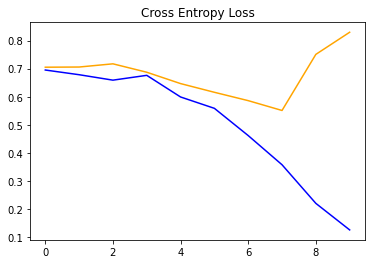

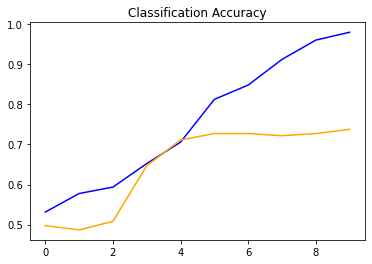

In [19]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

Podemos ver que la red neurona apesta bastante, además de que facilmente entra en overfitting... asi que la regression logística, con menos esfuerzo, funciona igual de mal.

In [20]:
_,score_test = model.evaluate(x_test, y_test)

print('Accuracy for IMDB data in test data with NN: {:.4f}'.format(score_test))

6/6 [==============================] - 0s 4ms/step - loss: 0.8295 - accuracy: 0.7380
Accuracy for IMDB data in test data with NN: 0.7380
